# RAVE Latent Space Exploration

In [1]:
import librosa
import torch
import torchaudio
import IPython.display as ipd
import numpy as np
import tempfile
import soundfile as sf
import os

import rave

from pydub import AudioSegment
from pydub.playback import play

In [2]:
tapped_dict = {
    "ac_dc": "../data/tapped/ac_dc-back_in_black-tapped.flac",
    "amy_winehouse": "../data/tapped/Tears Dry On Their Own - Amy Whinehouse-tapped.flac",
    "amália": "../data/tapped/Barco Negro (Mão Preta) - Amália Rodrigues-tapped.flac",
    "arctic_monkeys": "../data/tapped/arctic_monkeys-the_view_from_the_afternoon-tapped.flac",
    "beatles1": "../data/tapped/Come Together - The Beatles-tapped.flac",
    "beatles2": "../data/tapped/the_beatles-in_my_life-tapped.flac",
    "capitão_fausto": "../data/tapped/Morro na Praia - Capitão Fausto-tapped.flac",
    "david_miguel": "../data/tapped/Inatel - David e Miguel-tapped.flac",
    "gorillaz": "../data/tapped/Clint Eastwood - Gorillaz-tapped.flac",
    "ibeyi": "../data/tapped/River - Ibeyi-tapped.flac",
    "linda_martini": "../data/tapped/Febril - Linda Martini-tapped.flac",
    "michael_jackson": "../data/tapped/Billie Jean - Michael Jackson-tapped.flac",
    "qotsa": "../data/tapped/qotsa_no_one_knows-tapped.flac",
    "queen": "../data/tapped/queen-another_one_bites_the_dust-tapped.flac",
    "slowj": "../data/tapped/slowj-mundança-tapped.flac",
    "strokes": "../data/tapped/Reptilia - The Strokes-tapped.flac",
    "white_stripes": "../data/tapped/white_stripes-seven_nation_army-tapped.flac"
}

In [3]:
def read_audio(file_path, trim_interval=None, mono=True, print_it=False):
    audio, sr = librosa.load(file_path, mono=mono)
    audio_dim = len(audio.shape)
    if not mono and audio_dim == 1:
        audio = np.asarray((audio, audio))
    if trim_interval is not None:
        ti = trim_interval[0]
        tf = trim_interval[1]
        audio = trim_audio(audio, sr, ti, tf, mono)
    if print_it:
        print(audio.shape)
        print(sr)
    return audio, sr

def trim_audio(audio, sr, ti, tf, mono=True):
    i = ti * sr
    f = tf * sr
    if mono:
        t_audio = audio[i:f]
    else:
        t_audio = audio[:, i:f]
    return t_audio


def remix_audio(left_audio_array, right_audio_array, sample_rate=44100):
    # Ensure both audio arrays have the same length
    length = min(len(left_audio_array), len(right_audio_array))
    left_audio_array = left_audio_array[:length]
    right_audio_array = right_audio_array[:length]

    # Create a stereo audio array with left channel and right channel
    stereo_audio_array = np.column_stack((left_audio_array, right_audio_array))

    # Save the remixed audio to the specified output path
    #sf.write(output_path, stereo_audio_array, sample_rate)

    return stereo_audio_array

In [4]:
#song = "ac_dc"
#song = "amália"
#song = "amy_winehouse"
#song = "arctic_monkeys"
#song = "beatles1"
#song = "beatles2"
##song = "capitão_fausto"
#song = "david_miguel"
#song = "gorillaz"
#song = "ibeyi"
#song = "linda_martini"
#song = "michael_jackson"
#song = "qotsa"
##song = "queen"
song = "slowj"
#song = "strokes"
#song = "white_stripes"

trim = True

trim_interval = None
# choose the interval in which you want to trim the audio (in seconds)
if trim:
    trim_interval = (15, 17)


In [5]:
tapped_path = tapped_dict[song]
#tapped_path = '../data/KickSequence.wav'

tapped_audio, sr = read_audio(tapped_path, trim_interval)
ipd.Audio(tapped_audio, rate=sr)

In [6]:
model_name = 'GMDrums_v3_29-09_3M_streaming'
model_name = 'percussion'
#model_name = 'darbouka_onnx'
#model_name = 'drumkit_v1'
model = torch.jit.load(f'../models/{model_name}.ts')

desired_length = 44100

# Calculate the amount of padding needed
padding_width = max(0, desired_length - len(tapped_audio))
print(len(tapped_audio))

# Pad the array with zeros
tapped_audio = np.pad(tapped_audio, (0, padding_width), mode='constant', constant_values=0)

with torch.no_grad():
    x = torch.from_numpy(tapped_audio).reshape(1,1,-1)

    # encode and decode the audio with RAVE
    z = model.encode(x)
    tapped_latent_space_matrix = torch.squeeze(z, 0)
    #print(latent_space_matrix)


    x_hat = model.decode(z)
tapped_rave_audio = torch.squeeze(x_hat, 0)

44100


In [7]:
ipd.Audio(tapped_rave_audio, rate=sr)

In [8]:
import torch
import torch.nn.functional as F

def calculate_distance(tensor1, tensor2, distance_metric='euclidean'):
    if distance_metric == 'euclidean':
        return F.pairwise_distance(tensor1, tensor2)
    elif distance_metric == 'cosine':
        return 1 - F.cosine_similarity(tensor1, tensor2)
    else:
        raise ValueError("Unsupported distance metric")
    
kick_path = '/home/asantos-6/Documents/PhD/code/RAVERs/data/WAV/Individual Hits/01. Bass Drum/01. Clean/03. Long/BD 909 Clean Long A 01.wav'

kick_audio, sr = read_audio(kick_path)

# Calculate the amount of padding needed
padding_width = max(0, desired_length - len(kick_audio))

# Pad the array with zeros
padded_kick_audio = np.pad(kick_audio, (0, padding_width), mode='constant', constant_values=0)

with torch.no_grad():
    x = torch.from_numpy(padded_kick_audio).reshape(1,1,-1)

    # encode and decode the audio with RAVE
    z = model.encode(x)
    kick_latent_space_matrix = torch.squeeze(z, 0)

    x_hat = model.decode(z)
    kick_rave_audio = torch.squeeze(x_hat, 0)

#distance = calculate_distance(tapped_latent_space_matrix, kick_latent_space_matrix, distance_metric='euclidean')
#print(distance)

In [9]:
ipd.Audio(padded_kick_audio, rate=sr)

In [10]:
ipd.Audio(kick_rave_audio, rate=sr)

In [11]:
ipd.Audio(tapped_audio, rate=sr)

In [12]:
def interpolate_tensors(tensor1, tensor2, alpha):
    return alpha * tensor1 + (1 - alpha) * tensor2

# Example usage
alpha_value = 0.5  # Adjust alpha as needed
interpolated_tensor = interpolate_tensors(kick_latent_space_matrix, tapped_latent_space_matrix, alpha_value)

with torch.no_grad():

    z = torch.unsqueeze(interpolated_tensor, 0)
    print(interpolated_tensor.shape)


    x_hat = model.decode(z)
waveform_tensor = torch.squeeze(x_hat, 0)


torch.Size([4, 22])


In [13]:
output_file = 'output.wav'
torchaudio.save(output_file, waveform_tensor, sr)

interpolated_audio, sr = read_audio(output_file)
print(interpolated_audio.shape)

ipd.Audio(interpolated_audio, rate=sr)

(45056,)


In [14]:
import os

def find_files_with_keyword(folder_path, keyword):
    matching_files = []
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Check if the file is a regular file and contains the keyword
        if os.path.isfile(file_path) and keyword in filename:
            matching_files.append(file_path)

    return sorted(matching_files)

# Replace 'your_folder_path' with the path to the folder you want to search
folder_path = '../data/Roland TR-909'
keyword = 'Kick'

kick_files = find_files_with_keyword(folder_path, keyword)

kick_files.append('../data/Roland TR-909/TR-909Crash.wav')

# Print the list of matching files
#print(f"Files in '{folder_path}' containing the keyword '{keyword}':")
#for file_path in matching_files:
#    print(file_path)


In [15]:
import os
import glob

def find_wav_files(folder_path):
    wav_files = []
    
    # Use os.walk to traverse the directory tree
    for root, dirs, files in os.walk(folder_path):
        # Use glob to find .wav files in the current directory
        wav_files.extend(glob.glob(os.path.join(root, '*.wav')))
    
    return wav_files

# Example usage
folder_path = '../data/WAV/Individual Hits'
wav_files = find_wav_files(folder_path)

print("Found .wav files:")
#for wav_file in wav_files:
    #print(wav_file)
print(len(wav_files))

Found .wav files:
1410


In [16]:
with torch.no_grad():

    z = torch.unsqueeze(tapped_latent_space_matrix, 0) 
    x_hat = model.decode(z)
tapped_rave_original = torch.squeeze(x_hat, 0)

In [17]:
ipd.Audio(tapped_rave_original, rate=sr)

In [18]:
with torch.no_grad():

    z = torch.unsqueeze(kick_latent_space_matrix, 0) 
    x_hat = model.decode(z)
kick_rave_original = torch.squeeze(x_hat, 0)

In [19]:
ipd.Audio(kick_rave_original, rate=sr)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

def interpolate_one_dimension(point1, point2, t, dim):
    result = np.copy(point1)
    result[dim, :] = (1 - t) * point1[dim, :] + t * point2[dim, :]
    return result

# Example with random points in a 16x22 latent space
latent_point1 = kick_latent_space_matrix
latent_point2 = tapped_latent_space_matrix

# Choose the dimension to interpolate (e.g., the first dimension, dim=0)
interpolated_dimension = 0

# Interpolate with t in the range [0, 1]
t_values = np.linspace(0, 1, num=10)
interpolated_points = [interpolate_one_dimension(latent_point1, latent_point2, t, interpolated_dimension) for t in t_values]
print(interpolated_points[0].shape)

# Visualization (assuming 16x22 latent space)
#plt.plot(latent_point1[:, interpolated_dimension], label='Point 1')
#plt.plot(latent_point2[:, interpolated_dimension], label='Point 2')
#for i, t in enumerate(t_values):
#    plt.plot(interpolated_points[i][:, interpolated_dimension], label=f'Interpolated {t:.2f}')

#plt.legend()
#plt.title(f'Linear Interpolation along Dimension {interpolated_dimension}')
#plt.show()


(4, 22)


In [21]:
import torch
import pandas as pd

def colorize(value):
    # Map values to color gradients (modify this based on your needs)
    color = f"rgba({int(255 * value)}, 0, {int(255 * (1 - value))}, 1)"
    return f"background-color: {color}"

# Create a PyTorch tensor
tensor = kick_latent_space_matrix

# Convert the PyTorch tensor to a Pandas DataFrame
df = pd.DataFrame(tensor.numpy())

# Apply the color function to the entire DataFrame
styled_df = df.style.applymap(colorize)

# Display the styled DataFrame
styled_df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-1.550579,1.568193,0.182533,-2.506007,-1.212261,-1.075747,-0.772369,-1.014372,-1.868520,-1.666254,-1.337166,-0.843041,-0.743504,-1.237911,-1.026767,-1.154949,-1.048478,-0.935260,-0.772516,-1.045102,-0.388126,-0.821903
1,-0.559624,4.748236,0.386486,-0.837486,-1.278529,-0.289056,-1.259013,-0.094726,-0.388090,-0.475678,-0.665765,-1.090477,-0.325399,0.687152,-0.621303,0.533603,-0.652425,0.313814,0.492512,0.798252,1.774855,-0.919117
2,0.159032,-3.039948,0.044105,-2.096126,0.540442,0.088714,-2.463515,-1.221621,0.425671,1.390881,0.932450,-0.618089,-0.516316,1.342737,2.777692,-0.199238,-1.330804,0.303920,-0.526289,0.227692,-0.081115,-0.263621
3,-1.387975,-0.326092,-2.662241,-1.035015,1.620299,0.563717,-1.418212,-3.303158,0.391340,1.597486,1.152259,-0.320566,-2.891042,-1.881749,-1.140741,0.677883,2.130747,-1.615789,-1.772563,0.848795,-2.524645,0.215792


In [22]:
with torch.no_grad():

    z = torch.unsqueeze(kick_latent_space_matrix, 0) 
    x_hat = model.decode(z)
mix_rave = torch.squeeze(x_hat, 0)

In [23]:
ipd.Audio(mix_rave, rate=sr)

In [24]:
# Create a PyTorch tensor
tensor = tapped_latent_space_matrix

# Convert the PyTorch tensor to a Pandas DataFrame
df = pd.DataFrame(tensor.numpy())

# Apply the color function to the entire DataFrame
styled_df = df.style.applymap(colorize)

# Display the styled DataFrame
styled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-0.988493,-0.513512,-0.764535,-0.619666,-0.891395,0.370327,-0.469355,-1.050005,-1.581586,0.010732,-0.686093,-0.993074,-1.497929,0.077783,-0.774248,-0.665748,-1.450375,-0.762841,0.380096,-2.399679,-0.800255,-0.691370
1,0.459871,-0.393567,0.757570,-0.683959,0.774008,-0.632929,-0.173073,-0.096679,0.615032,0.360377,-2.390068,-0.681510,0.360124,-0.535603,-0.777270,-0.378239,1.187697,0.285900,-0.145901,0.307624,-0.036372,-0.103187
2,0.081254,-3.091881,0.215312,0.437331,0.695482,0.016039,-1.654953,0.315117,0.169717,-1.504109,-1.556165,-0.454043,0.384465,-0.638535,-0.052045,0.012813,-1.150227,-1.119389,-0.901381,2.167410,-1.684913,-0.879942
3,-0.279649,0.917699,-1.392925,0.623799,-0.844755,0.153244,-1.593357,-2.780971,-0.674385,0.442185,-0.826425,1.408236,-0.193907,0.314068,0.075198,-0.811801,-0.284656,0.230202,0.280896,0.301647,-1.416794,1.281637


In [25]:
with torch.no_grad():

    z = torch.unsqueeze(tapped_latent_space_matrix, 0) 
    x_hat = model.decode(z)
mix_rave = torch.squeeze(x_hat, 0)

In [26]:
ipd.Audio(mix_rave, rate=sr)

In [27]:
import torch

# Specify the columns to be replaced (5-7) with columns from kick_latent_space_matrix (1-3)
columns_to_replace = slice(0, 22)
columns_from_kick = slice(1, 2)

mix_tapped_latent_space_matrix = tapped_latent_space_matrix.clone()

# Replace columns
mix_tapped_latent_space_matrix[:, columns_to_replace] = kick_latent_space_matrix[:, columns_from_kick]

# Display the updated matrix
tensor = mix_tapped_latent_space_matrix

# Convert the PyTorch tensor to a Pandas DataFrame
df = pd.DataFrame(tensor.numpy())

# Apply the color function to the entire DataFrame
styled_df = df.style.applymap(colorize)

# Display the styled DataFrame
styled_df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193,1.568193
1,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236,4.748236
2,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948,-3.039948
3,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092,-0.326092


In [28]:
with torch.no_grad():

    z = torch.unsqueeze(mix_tapped_latent_space_matrix, 0) 
    x_hat = model.decode(z)
mix_rave = torch.squeeze(x_hat, 0)

In [29]:
ipd.Audio(mix_rave, rate=sr)

import torch

def split_and_concat(matrix1, matrix2):
    # Ensure tensors are 8x22
    if matrix1.size() != torch.Size([8, 22]) or matrix2.size() != torch.Size([8, 22]):
        raise ValueError("Input matrices must be 8x22 torch tensors")

    # Split each tensor in half
    half_columns = matrix1.size(1) // 2

    first_half_matrix1 = matrix1[:, :half_columns]
    second_half_matrix1 = matrix1[:, half_columns:]

    first_half_matrix2 = matrix2[:, :half_columns]
    second_half_matrix2 = matrix2[:, half_columns:]

    # Concatenate the first half of matrix1 with the second half of matrix2
    result_matrix = torch.cat((first_half_matrix1, second_half_matrix2), dim=1)

    return result_matrix

# Example usage:
matrix1 = kick_latent_space_matrix
print(type(matrix1))
matrix2 = tapped_latent_space_matrix

result = split_and_concat(matrix1, matrix2)
print(type(result))
with torch.no_grad():    
    z = torch.unsqueeze(result, 0)    
    print(z.shape)
    x_hat = model.decode(z)
    print(x_hat.shape)
half_and_half_audio = torch.squeeze(x_hat, 0)

In [31]:
ipd.Audio(half_and_half_audio, rate=sr)

NameError: name 'half_and_half_audio' is not defined

In [32]:
interpolated_audios=[]
for i in interpolated_points:
    with torch.no_grad():
    
        z = torch.unsqueeze(interpolated_tensor, 0)      
        x_hat = model.decode(z)
    interpolated_audios.append(torch.squeeze(x_hat, 0))

In [33]:
output_file = 'output.wav'

half_and_half = 

torchaudio.save(output_file, interpolated_audios[0], sr)

interpolated_audio, sr = read_audio(output_file)
print(interpolated_audio.shape)

ipd.Audio(interpolated_audio, rate=sr)

SyntaxError: invalid syntax (2146101903.py, line 3)

In [34]:
kick_latents = []
kick_filtered_files = []
for kick_path in wav_files:

    kick_audio, sr = read_audio(kick_path, print_it=False)
    #kick_audio = np.pad()
    #kick_audio = kick_audio[:1500]
    if kick_audio.shape[0] < 4410:
        continue
    
    kick_filtered_files.append(kick_path)
    desired_length = 44100

    # Calculate the amount of padding needed
    padding_width = max(0, desired_length - len(kick_audio))

    # Pad the array with zeros
    kick_audio = np.pad(kick_audio, (0, padding_width), mode='constant', constant_values=0)
    #print(kick_audio.shape)

    with torch.no_grad():
        x = torch.from_numpy(kick_audio).reshape(1,1,-1)

        # encode and decode the audio with RAVE
        z = model.encode(x)
        kick_latent_space_matrix = torch.squeeze(z, 0)
        kick_latents.append(kick_latent_space_matrix)

# Check the shapes of all tensors

tensor_shapes = [tensor.shape for tensor in kick_latents]
if all(shape == tensor_shapes[0] for shape in tensor_shapes):
    print("All have same shape")
#print(tensor_shapes)

kick_latents.append(tapped_latent_space_matrix)
kick_latents.extend(interpolated_points)


# Ensure all tensors have the same shape
if not all(shape == tensor_shapes[0] for shape in tensor_shapes):
    raise ValueError("All input tensors must have the same shape.")

# Convert each PyTorch tensor to a NumPy array
#latent_space_numpy = np.stack([tensor.numpy() for tensor in kick_latents], axis=0)
latent_space_numpy = np.array(kick_latents)
#print(latent_space_numpy)

# Now, latent_space_numpy is a NumPy array that you can use as input to UMAP
#kick_tensor = torch.cat(kick_latents, axis=1)
#kick_tensor = kick_tensor.permute(-1, 0)
#print(kick_tensor.shape)

All have same shape


In [35]:
import umap

# Reshape each tensor to a 1D array while preserving temporal order
flattened_tensors = [tensor.flatten() for tensor in kick_latents]

# Stack the flattened tensors into a 2D array
data_matrix = np.vstack(flattened_tensors)
print(data_matrix.shape)

# Apply UMAP
n_components = 2
umap_model = umap.UMAP(n_components=n_components)
umap_result = umap_model.fit_transform(data_matrix)

print(umap_result.shape)


(1057, 88)
(1057, 2)


In [36]:
def remove_common_part(file_names):
    # Find the common prefix
    common_prefix = os.path.commonprefix(file_names)
    
    # Find the common suffix (if needed)
    common_suffix = os.path.commonprefix([name[::-1] for name in file_names])[::-1]

    # Remove the common part from each file name
    modified_file_names = [name[len(common_prefix):] for name in file_names]

    return modified_file_names


modified_file_names = remove_common_part(kick_filtered_files)
modified_file_names.append(tapped_path)
kick_filtered_files.append(tapped_path)

for i in interpolated_points:
    modified_file_names.append(tapped_path)
    kick_filtered_files.append(tapped_path)

#print("Modified file names:", modified_file_names)

In [37]:
#import umap.plot
#umap.plot.points(umap_result)

(1057, 2)
1057


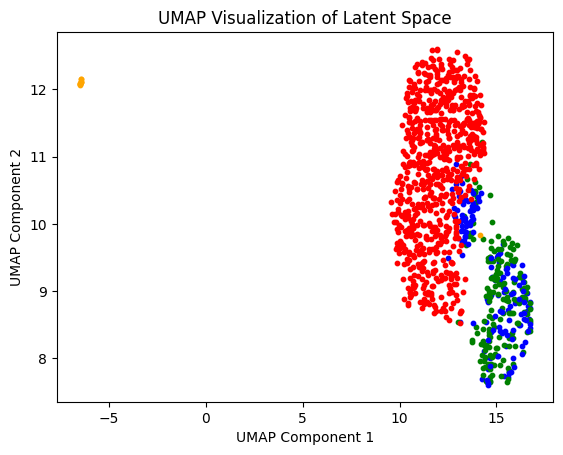

In [38]:
import matplotlib.pyplot as plt

# Visualize the UMAP result
for i, file_name in enumerate(modified_file_names):
    if "BD" in file_name:
        color = 'red'
    elif "SD" in file_name:
        color = 'green'
    elif "tapped" in file_name:
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(umap_result[i, 0], umap_result[i, 1], c=color, marker='o', s=10)
print(umap_result.shape)
print(len(modified_file_names))
    
plt.title('UMAP Visualization of Latent Space')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()


In [39]:
output_file = 'output.wav'
torchaudio.save(output_file, waveform_tensor, sr)

rave_audio, sr = read_audio(output_file)
print(rave_audio.shape)

ipd.Audio(rave_audio, rate=sr)

(45056,)


In [40]:
#!pip install fiftyone

In [41]:
#!pip install torch torchvision umap-learn

In [42]:
#!pip install 'ipywidgets>=8,<9'

In [47]:
import fiftyone as fo
import librosa

# Example list of audio file paths
audio_files = kick_filtered_files
audio_names = modified_file_names

# Create a FiftyOne SampleCollection
dataset = fo.Dataset()

# Iterate over audio files and create samples
for audio_file, audio_name in zip(audio_files, audio_names):
    # Load audio data using librosa or your preferred library
    audio_data, sample_rate = librosa.load(audio_file, sr=None)  # Adjust parameters as needed

    if "BD" in audio_name:
        label = 'BD'
    elif "SD" in audio_name:
        label = 'SD'
    elif "mundança" in audio_name:
        label = 'tap'
    else:
        label = 'other'
    
    # Create a FiftyOne Sample
    sample = fo.Sample(filepath=audio_file, audio=audio_data, sample_rate=sample_rate, label=label, audio_name=audio_name)

    # Add the sample to the dataset
    dataset.add_sample(sample)

# Save the SampleCollection (optional)
#dataset.save("../data")


In [48]:
#import fiftyone as fo
#import fiftyone.core.fields as fof
#import numpy as np

# Assume you have a latent tensor
#extra_latent_tensor = tapped_latent_space_matrix
#print(tapped_latent_space_matrix.shape)

# Create a new sample with the latent tensor
#sample = fo.Sample(filepath=tapped_path, label="input")

# Add the array field to the sample
#sample["latent_tensor"] = fof.ArrayField()

# Assign the latent tensor to the array field
#sample["latent_tensor"].value = extra_latent_tensor

# Add the sample to the dataset
#dataset.add_sample(sample)

In [49]:
import cv2
import numpy as np

import fiftyone.brain as fob

# Construct a ``num_samples x num_pixels`` array of images
embeddings = data_matrix

# Compute 2D representation
results = fob.compute_visualization(
    dataset,
    embeddings=embeddings,
    num_dims=2,
    method="tsne",
    brain_key="mnist_test",
    verbose=True,
    seed=51,
)

Generating visualization...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1057 samples in 0.000s...
[t-SNE] Computed neighbors for 1057 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1057
[t-SNE] Computed conditional probabilities for sample 1057 / 1057
[t-SNE] Mean sigma: 3.042874
[t-SNE] Computed conditional probabilities in 0.044s
[t-SNE] Iteration 50: error = 80.2023087, gradient norm = 0.3100177 (50 iterations in 0.174s)
[t-SNE] Iteration 100: error = 80.9036789, gradient norm = 0.2885276 (50 iterations in 0.084s)
[t-SNE] Iteration 150: error = 81.2615433, gradient norm = 0.2811396 (50 iterations in 0.093s)
[t-SNE] Iteration 200: error = 83.0838318, gradient norm = 0.2528467 (50 iterations in 0.146s)
[t-SNE] Iteration 250: error = 81.2585297, gradient norm = 0.2546489 (50 iterations in 0.097s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.258530
[t-SNE] Iteration 300: error = 2.4033415, gradient norm = 0.00377

In [51]:
import pandas as pd

df = pd.DataFrame(results.points, columns=['x', 'y'])
df['label'] = dataset.values('label')
df['audio_name'] = dataset.values('audio_name')
df['filepath'] = dataset.values('filepath')

df.head()

,x,y,label,audio_name,filepath
0,12.521315,14.878491,other,5. Hand Clap/03. Various/Clap 909 Various 02.wav,/home/asantos-6/Documents/PhD/code/RAVERs/data...
1,23.203075,3.786746,other,5. Hand Clap/03. Various/Clap 909 Various 06.wav,/home/asantos-6/Documents/PhD/code/RAVERs/data...
2,17.144342,15.724524,other,5. Hand Clap/03. Various/Clap 909 Various 01.wav,/home/asantos-6/Documents/PhD/code/RAVERs/data...
3,16.304565,11.543887,other,5. Hand Clap/03. Various/Clap 909 Various 08.wav,/home/asantos-6/Documents/PhD/code/RAVERs/data...
4,16.254438,8.849135,other,5. Hand Clap/03. Various/Clap 909 Various 09.wav,/home/asantos-6/Documents/PhD/code/RAVERs/data...


In [54]:
#!pip install dash

In [55]:
import plotly.graph_objs as go

# Create a scatter plot of the latent space
data = []
for label in df['label'].unique():
    df_label = df[df['label'] == label]
    scatter = go.Scatter(
        x=df_label['x'], 
        y=df_label['y'], 
        mode='markers',
        text=df_label['audio_name'],  # Add the audio name as text
        hovertemplate='%{text}<extra></extra>',  # Customize the hover template
        name=label,  # Use the label as the name of the trace
        customdata=df_label['filepath']  # Add the file path as custom data
    )
    scatter.on_click(lambda x: print(x.points[0].hovertext))  # Print the name of the point when it's clicked
    data.append(scatter)

fig = go.Figure(data=data)

# Adjust the margins (l, r, t, b stand for left, right, top, and bottom)
fig.update_layout(
    autosize=False,
    width=1000,
    height=400,
    margin=dict(l=24,r=24,b=24,t=24,pad=0)
)

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import base64
import io

def get_relative_path(absolute_path):
    base_path = os.getcwd()
    return os.path.relpath(absolute_path, base_path)

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='scatter-plot', figure=fig),
    html.Pre(id='click-data', style={'padding': '10px', 'color': 'white'}),
    html.Audio(id='input-player', controls=True, autoPlay=True),
    html.Audio(id='output-player', controls=True, autoPlay=False)
])

@app.callback(Output('click-data', 'children'), [Input('scatter-plot', 'clickData')])
def display_click_data(clickData):
    if clickData is None: return 'None'
    absolute_path = clickData["points"][0]["customdata"]
    base_path = os.getcwd()
    return os.path.relpath(absolute_path, base_path)

@app.callback(Output('input-player', 'src'), [Input('scatter-plot', 'clickData')])
def play_input(clickData):
    if clickData is None: return ''

    relative_path = get_relative_path(clickData["points"][0]["customdata"])
    with open(relative_path, 'rb') as audio_file:
        encoded_audio = base64.b64encode(audio_file.read()).decode('ascii')
    src = f'data:audio/mp3;base64,{encoded_audio}'
    
    return src

@app.callback(Output('output-player', 'src'), [Input('scatter-plot', 'clickData')])
def play_output(clickData):
    if clickData is None: return ''
    
    relative_path = get_relative_path(clickData["points"][0]["customdata"])

    audio, sr = read_audio(relative_path)
    with torch.no_grad():
        x = torch.from_numpy(audio).reshape(1 ,1, -1)
        z = model.encode(x)
        x_hat = model.decode(z)
    waveform_tensor = torch.squeeze(x_hat, 0)
    output_path = '../output/output.wav'
    torchaudio.save(output_path, waveform_tensor, sr)

    with open(output_path, 'rb') as audio_file:
        encoded_audio = base64.b64encode(audio_file.read()).decode('ascii')
    src = f'data:audio/mp3;base64,{encoded_audio}'

    return src

if __name__ == '__main__': app.run_server(debug=True)

In [ ]:
print(type(results))
print(results.points.shape)

In [ ]:
session = fo.launch_app()
session.dataset = dataset

In [ ]:
plot = results.visualize(labels="label")
plot.show(height=720)

session.plots.attach(plot)

In [ ]:
fo.close_app()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Apply PCA
pca = PCA()
latent_space_pca = pca.fit_transform(latent_space_matrix)
print(latent_space_pca)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.show()

# Print the principal components
print('Principal Components:')
print(pca.components_.shape)
print(pca.components_)

In [ ]:
pca = PCA(n_components=2)
latent_space_2d = pca.fit_transform(latent_space_matrix)

# Scatter plot
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1])
plt.title('Latent Space Matrix in 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
ipd.Audio(tapped_audio, rate=sr)

In [ ]:
remixed_audio = remix_audio(tapped_audio, rave_audio, sample_rate=sr)

normalized_audio = remixed_audio / np.max(np.abs(remixed_audio))

# Convert to 16-bit PCM format
pcm_audio = (normalized_audio * 32767).astype(np.int16)

# Save the PCM audio data to a temporary WAV file
with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_wav:
    sf.write(temp_wav.name, pcm_audio, sr)

# Display the audio using ipd.Audio
ipd.display(ipd.Audio(temp_wav.name))

# Clean up the temporary file
os.remove(temp_wav.name)

In [ ]:
import numpy as np
import librosa
from scipy.signal import correlate

# Assuming rave_audio and tapped_audio are your stereo audio data with shape (length, 2)
# Replace them with your actual stereo audio data

# Choose one channel for onset detection (e.g., left channel)
rave_channel = rave_audio
tapped_channel = tapped_audio

# Normalize the audio to the range [-1, 1]
rave_channel_normalized = rave_channel / np.max(np.abs(rave_channel))
tapped_channel_normalized = tapped_channel / np.max(np.abs(tapped_channel))

# Compute onsets using librosa onset detection
rave_onsets = librosa.onset.onset_detect(rave_channel_normalized, sr=sr)
tapped_onsets = librosa.onset.onset_detect(tapped_channel_normalized, sr=sr)

# Compute cross-correlation
cross_corr = correlate(rave_channel_normalized, tapped_channel_normalized, mode='full')

# Find the time lag (shift) with maximum cross-correlation
time_lag = np.argmax(cross_corr) - len(rave_channel_normalized) + 1

# Shift the tapped_audio to align with rave_audio
aligned_tapped_audio = np.roll(tapped_audio, time_lag, axis=0)

# Now, aligned_tapped_audio and rave_audio are aligned based on onset detection

# Display the aligned audio using ipd.Audio
ipd.display(ipd.Audio(aligned_tapped_audio, rate=sr))